In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from asteria.stellardist import StellarDensity
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize

In [2]:
def diff(x, r):
    diff = np.abs(Dist2Rate(x) - r)
    return float(diff)

def Dist2Rate(d):
    return sd_ccsn_rate(d)

def Rate2Dist(r_in):
    if not isinstance(r_in, np.ndarray):
        if r_in > sd_ccsn_tot_rate:
            r_in = sd_ccsn_tot_rate
        res = minimize(diff, x0=10, args=r_in)
        return res.x
    else:
        np.where(r_in>sd_ccsn_tot_rate,sd_ccsn_tot_rate,r_in)
        r_out = []
        for rr in r_in:
            res = minimize(diff, x0=10, args=rr)
            r_out.append(res.x)
        r_out = np.array(r_out)
        return r_out
    
def diff_cdf(x, cdf_val):
    if x > 25 + 1E-3: #everything above 25 kpc has a probability of 100%, but we want the 'edge' so we punish any
        # value that is higher than 25 kpc + epsilon, epsilon << 1
        return 1E6
    else:
        diff = np.abs(sd_cdf(x) - cdf_val)
        return float(diff)
    
def inv_cdf(cdf_val):
    if not isinstance(cdf_val, np.ndarray):
        res = minimize(diff_cdf, x0 = 5, args=cv)
        return res.x
    else:
        d = []
        for cv in cdf_val:
            loss, i = 1, 0
            x0s = np.array([5,10,15,20])
            while loss > 1E-3:
                res = minimize(diff_cdf, x0 = x0s[i], args=cv)
                loss = res.fun
                i += 1
                if i > 3:
                    print('Fit failed to converge!')
                    break
            d.append(res.x)
        d = np.array(d)
        return d

In [3]:
trials = 1E4
time_indep = True
if time_indep == True:
    add_string = 'timeindep_'
else:
    add_string = ''
file1 = open('./files/results_frequency_'+add_string+'IC86+Gen2_{:.0E}_trials.pkl'.format(trials), 'rb')
data1 = pickle.load(file1)
file2 = open('./files/results_frequency_'+add_string+'IC86+Gen2+WLS_{:.0E}_trials.pkl'.format(trials), 'rb')
data2 = pickle.load(file2)

cut_freq = 75 * u.Hz
distances1, Sts1_gen2, Sts1_ic86, Bts1_gen2, Bts1_ic86, Z1_gen2, Z1_ic86 = data1
distances2, Sts2_gen2, Sts2_ic86, Bts2_gen2, Bts2_ic86, Z2_gen2, Z2_ic86 = data2

In [4]:
# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity('../../../../data/stellar/sn_radial_distrib_adams.fits', add_LMC=False, add_SMC=False)

dmax = np.max((distances1,distances2))*u.kpc
sd_cdf = PchipInterpolator(sd.dist.value, sd.cdf)

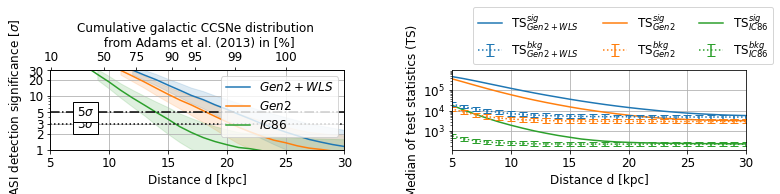

In [31]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax = ax.ravel()

ax[0].plot(distances1, Z2_gen2.T[0], color = 'C0', label=r'$Gen2+WLS$')
ax[0].plot(distances1, Z1_gen2.T[0], color = 'C1', label=r'$Gen2$')
ax[0].plot(distances1, Z1_ic86.T[0], color = 'C2', label=r'$IC86$')

ax[0].fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C0')
ax[0].fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax[0].fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C2')

ax[0].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[0].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 12)
ax[0].set_xlim((5,30))
ax[0].set_ylim((1,30))

ax[0].tick_params(labelsize = 12)

ax[0].set_yscale('log')
ax[0].set_yticks([1,2,3,5,10,20,30])
ax[0].set_yticklabels(['1','2','3','5','10','20','30'])

ax[0].grid()
ax[0].legend(loc='upper right', fontsize = 12)

ax[0].axhline(3, color='k', ls = ':')
ax[0].axhline(5, color='k', ls = '-.')
ax[0].text(8, 3, r"3$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[0].text(8, 5, r"5$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax[0].twiny()
ax22.set_xlim(ax[0].get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 12)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 12)

#signal without errorbar
ax[1].plot(distances2, Sts2_gen2.T[0], color = 'C0', label=r'TS$^{sig}_{Gen2+WLS}$')
ax[1].plot(distances1, Sts1_gen2.T[0], color = 'C1', label=r'TS$^{sig}_{Gen2}$')
ax[1].plot(distances1, Sts1_ic86.T[0], color = 'C2', label=r'TS$^{sig}_{IC86}$')

#background with errorbar
ax[1].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{Gen2+WLS}$')
ax[1].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{Gen2}$')
ax[1].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C2', ls = ':', label=r'TS$^{bkg}_{IC86}$')

#rearrange legend handels
handles,labels = ax[1].get_legend_handles_labels()

handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]


ax[1].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[1].set_ylabel('Median of test statistics (TS)', fontsize = 12)
ax[1].set_xlim((5,30))
ax[1].set_yscale('log')
ax[1].tick_params(labelsize = 12)
ax[1].legend(handles, labels, ncol = 3, fontsize = 12, bbox_to_anchor=(0.05, 1))
ax[1].grid()

plt.tight_layout()
plt.savefig('./plots/final.png', dpi = 200, facecolor = 'white')

In [33]:
sig_wls_50 = PchipInterpolator(distances1[distances1>11*u.kpc], Z2_gen2[distances1>11*u.kpc].T[0])
sig_gen2_50 = PchipInterpolator(distances1[distances1>10*u.kpc], Z1_gen2[distances1>10*u.kpc].T[0])
sig_ic86_50 = PchipInterpolator(distances1[distances1>8*u.kpc], Z1_ic86[distances1>8*u.kpc].T[0])

sig_wls_14 = PchipInterpolator(distances1[distances1>11*u.kpc], Z2_gen2[distances1>11*u.kpc].T[1])
sig_gen2_14 = PchipInterpolator(distances1[distances1>10*u.kpc], Z1_gen2[distances1>10*u.kpc].T[1])
sig_ic86_14 = PchipInterpolator(distances1[distances1>8*u.kpc], Z1_ic86[distances1>8*u.kpc].T[1])

sig_wls_86 = PchipInterpolator(distances1[distances1>11*u.kpc], Z2_gen2[distances1>11*u.kpc].T[2])
sig_gen2_86 = PchipInterpolator(distances1[distances1>10*u.kpc], Z1_gen2[distances1>10*u.kpc].T[2])
sig_ic86_86 = PchipInterpolator(distances1[distances1>8*u.kpc], Z1_ic86[distances1>8*u.kpc].T[2])

sd_ccsn = PchipInterpolator(sd.dist.value, sd.cdf)

In [64]:
for sig in [3,5]:
    print("{} sigma detection level".format(sig))
    for det in ["wls", "gen2", "ic86"]:
        print(det)
        if det == "wls":
            funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
        elif det == "gen2":
            funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
        elif det == "ic86":
            funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]
           
        dist, perc = [], []
        for func in funcs:
            res = minimize(lambda v: np.sqrt(np.sum((func(v)-sig)**2)), x0=10)
            dist.append(res.x)
            if res.x >= 25:
                perc.append(np.array([1]))
            else:
                perc.append(sd_ccsn(res.x))
        dist = np.concatenate(dist)
        perc = np.concatenate(perc)*100
        print(dist)
        print("Distance: ({:.2f}+{:.2f}-{:.2f}) kpc".format(dist[1], dist[2]-dist[1], dist[1]-dist[0]))
        print("Coverage: ({:.2f}+{:.2f}-{:.2f}) kpc \n".format(perc[1], perc[2]-perc[1], perc[1]-perc[0]))

3 sigma detection level
wls
[20.58544328 23.0653155  26.99465577]
Distance: (23.07+3.93-2.48) kpc
Coverage: (99.88+0.12-0.93) kpc 

gen2
[18.22806964 20.40789745 23.75194422]
Distance: (20.41+3.34-2.18) kpc
Coverage: (98.83+1.12-2.24) kpc 

ic86
[13.90537014 15.65142363 18.39200916]
Distance: (15.65+2.74-1.75) kpc
Coverage: (91.02+5.81-6.75) kpc 

5 sigma detection level
wls
[18.5879889  20.57861507 23.29622032]
Distance: (20.58+2.72-1.99) kpc
Coverage: (98.95+0.96-1.86) kpc 

gen2
[16.50605019 18.25229446 20.60038724]
Distance: (18.25+2.35-1.75) kpc
Coverage: (96.63+2.33-3.29) kpc 

ic86
[12.60552932 13.97554543 16.3265517 ]
Distance: (13.98+2.35-1.37) kpc
Coverage: (84.60+8.30-7.63) kpc 



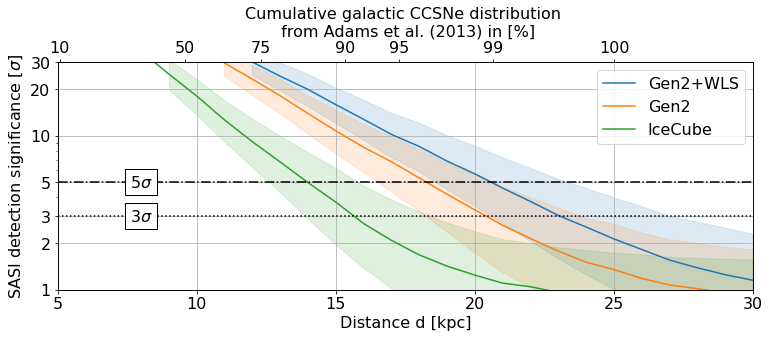

In [42]:
fig, ax = plt.subplots(1,1, figsize = (12,6))
font = {'size'   : 50}

mpl.rc('font', **font)

ax.plot(distances1, Z2_gen2.T[0], color = 'C0', label=r'Gen2+WLS')
ax.plot(distances1, Z1_gen2.T[0], color = 'C1', label=r'Gen2')
ax.plot(distances1, Z1_ic86.T[0], color = 'C2', label=r'IceCube')

ax.fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C0')
ax.fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax.fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C2')

ax.set_xlabel('Distance d [kpc]', fontsize = 16)
ax.set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 16)
ax.set_xlim((5,30))
ax.set_ylim((1,30))

ax.tick_params(labelsize = 16)

ax.set_yscale('log')
ax.set_yticks([1,2,3,5,10,20,30])
ax.set_yticklabels(['1','2','3','5','10','20','30'])

ax.grid()
ax.legend(loc='upper right', fontsize = 16)

ax.axhline(3, color='k', ls = ':')
ax.axhline(5, color='k', ls = '-.')
ax.text(8, 3, r"3$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax.text(8, 5, r"5$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax.twiny()
ax22.set_xlim(ax.get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('./plots/old.pdf', dpi = 300, facecolor = 'white')

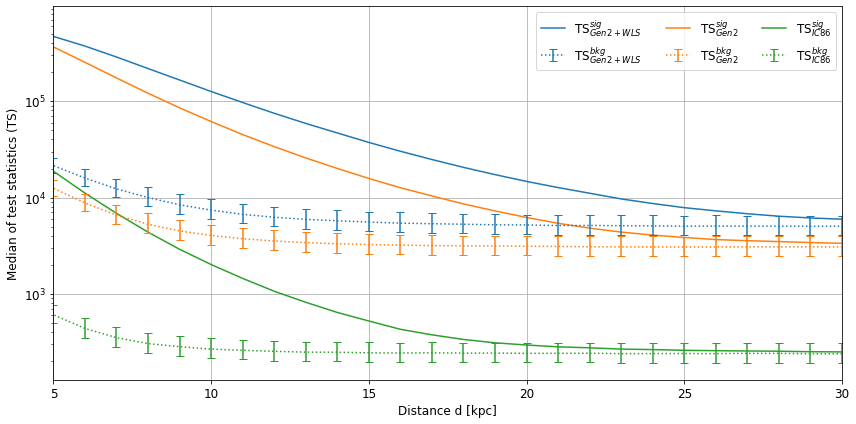

In [7]:
fig, ax = plt.subplots(1,1, figsize = (12,6))

#signal without errorbar
ax.plot(distances2, Sts2_gen2.T[0], color = 'C0', label=r'TS$^{sig}_{Gen2+WLS}$')
ax.plot(distances1, Sts1_gen2.T[0], color = 'C1', label=r'TS$^{sig}_{Gen2}$')
ax.plot(distances1, Sts1_ic86.T[0], color = 'C2', label=r'TS$^{sig}_{IC86}$')

#background with errorbar
ax.errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{Gen2+WLS}$')
ax.errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{Gen2}$')
ax.errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C2', ls = ':', label=r'TS$^{bkg}_{IC86}$')

#rearrange legend handels
handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]


ax.set_xlabel('Distance d [kpc]', fontsize = 12)
ax.set_ylabel('Median of test statistics (TS)', fontsize = 12)
ax.set_xlim((5,30))
ax.set_yscale('log')
ax.tick_params(labelsize = 12)
ax.legend(handles, labels, ncol = 3, fontsize = 12)
ax.grid()
plt.tight_layout()


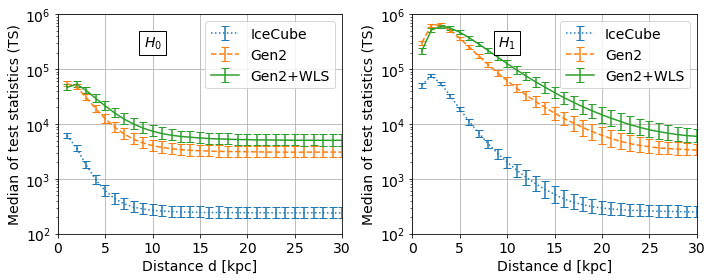

In [25]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

#background with errorbar
ax[0].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[0].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[0].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[0].text(10, 3E5, r"$H_0$", size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


#signal without errorbar

ax[1].errorbar(x=distances1, y=Sts1_ic86.T[0],yerr=(Sts1_ic86.T[0]-Sts1_ic86.T[1],Sts1_ic86.T[2]-Sts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[1].errorbar(x=distances1, y=Sts1_gen2.T[0],yerr=(Sts1_gen2.T[0]-Sts1_gen2.T[1],Sts1_gen2.T[2]-Sts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[1].errorbar(x=distances2, y=Sts2_gen2.T[0],yerr=(Sts2_gen2.T[0]-Sts2_gen2.T[1],Sts2_gen2.T[2]-Sts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[1].text(10, 3E5, r"$H_1$", size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)

for i in range(2):
    ax[i].set_xlabel('Distance d [kpc]', fontsize = 14)
    ax[i].set_ylabel('Median of test statistics (TS)', fontsize = 14)
    ax[i].set_xlim((0,30))
    ax[i].set_ylim((1E2,1E6))
    ax[i].set_yscale('log')
    ax[i].tick_params(labelsize = 14)
    ax[i].legend(fontsize = 14)
    ax[i].grid()
plt.tight_layout()
plt.savefig('../../lic/plots/ftf_tsdistance.pdf', dpi = 200, facecolor = 'white')

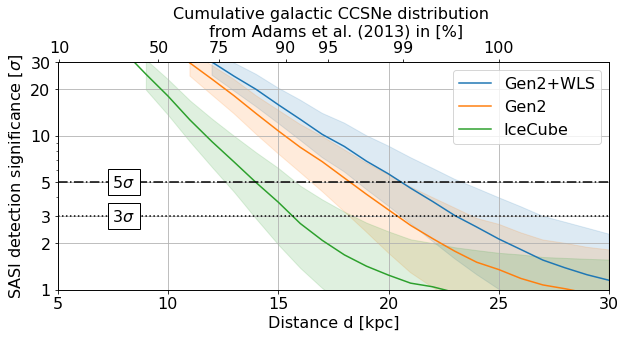

In [29]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
font = {'size'   : 50}

mpl.rc('font', **font)

ax.plot(distances1, Z2_gen2.T[0], color = 'C0', label=r'Gen2+WLS')
ax.plot(distances1, Z1_gen2.T[0], color = 'C1', label=r'Gen2')
ax.plot(distances1, Z1_ic86.T[0], color = 'C2', label=r'IceCube')

ax.fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C0')
ax.fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax.fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C2')

ax.set_xlabel('Distance d [kpc]', fontsize = 16)
ax.set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 16)
ax.set_xlim((5,30))
ax.set_ylim((1,30))

ax.tick_params(labelsize = 16)

ax.set_yscale('log')
ax.set_yticks([1,2,3,5,10,20,30])
ax.set_yticklabels(['1','2','3','5','10','20','30'])

ax.grid()
ax.legend(loc='upper right', fontsize = 16)

ax.axhline(3, color='k', ls = ':')
ax.axhline(5, color='k', ls = '-.')
ax.text(8, 3, r"3$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax.text(8, 5, r"5$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax.twiny()
ax22.set_xlim(ax.get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('../../lic/plots/ftf_freq_results.pdf', dpi = 200, facecolor = 'white')